# Welcome to the OnSSET model for Somaliland

This interface is built upon the [OnSSET](http://www.onsset.org/) tool and aims at providing an easy and quick way to generate electrification investment scenarios for Somaliland.

#### Start by importing the code 

In [1]:
from onsset import *
from onsset.funcs import *
import os
from IPython.display import display, Markdown, HTML
import tkinter as tk
from tkinter import filedialog, messagebox
from openpyxl import load_workbook
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import folium
import matplotlib.pylab as plt
import seaborn as sns
from onsset.map_funcs import *

# 1. GIS data selection

First, run the cell below to load the CSV file with GIS-data for Somalia: *Somalia_GIS_inputs.csv* 

In [4]:
input_file = 'Somaliland_GIS_Input.csv'


onsseter = SettlementProcessor(input_file)
onsseter.df['IsUrban'] = 0
onsseter.df['PerCapitaDemand'] = 0
onsseter.condition_df()
onsseter.df[SET_GRID_PENALTY] = onsseter.grid_penalties(onsseter.df)
onsseter.df.fillna(1, inplace=True)
onsseter.df[SET_WINDCF] = onsseter.calc_wind_cfs()

display(Markdown('#### The csv file has been imported correctly. Here is a preview:'))
display(onsseter.df[['Country','Pop','NightLights','TravelHours','GHI','WindVel','Hydropower','HydropowerDist']])

#### The csv file has been imported correctly. Here is a preview:

,Country,Pop,NightLights,TravelHours,GHI,WindVel,Hydropower,HydropowerDist
92228,Somaliland,9.0,0.000000,0.108394,2212.000000,6.503630,486.44,401.623308
92229,Somaliland,9.0,0.000000,0.107412,2212.000000,6.444726,486.44,402.086943
92225,Somaliland,33.0,0.000000,0.106955,2212.000000,6.417278,486.44,401.769200
92224,Somaliland,9.0,0.000000,0.109867,2212.000000,6.592036,486.44,401.546500
92226,Somaliland,5.0,0.000000,0.106989,2212.000000,6.419338,486.44,402.267467
...,...,...,...,...,...,...,...,...
2,Somaliland,116.0,0.000000,0.074111,2169.000000,4.446671,486.44,746.190410
4,Somaliland,14.0,0.000000,0.071948,2163.000000,4.316866,486.44,746.554851
3,Somaliland,9.0,0.000000,0.074514,2174.000000,4.470838,486.44,746.013246
1,Somaliland,144.0,0.000000,0.071965,2165.981984,4.317912,486.44,748.381899


# 2. Modelling period and target electrification rate

Next, define the modelling period and the electrification rate to be achieved by the end of the analysis, as well as the intermediate year and target.

In [5]:
start_year = 2020                 # The start year of the analysis
intermediate_year = 2025          # The intermediate year for the results
end_year = 2030                   # The end year for the results

intermediate_year_electrification_rate_target = 0.75 # E.g. 1 for 100% electrification rate or 0.80 for 80% electrification rate, to be achieved by the intermediate year
end_year_electrification_rate_target = 1 # E.g. 1 for 100% electrification rate or 0.80 for 80% electrification rate, to be achieved by the intermediate year

# 3. Socio- and techno-economic data

In this section the user can customize a number of variables describing the social - economic - technological environment for the analysis. 

### a. Demographics and Social components

In [6]:
pop_start_year = 3500000          ### Write the population in the base year (e.g. 2020) 

urban_pop_growth_rate = 0.029     ### Write the annual population growth rate expected in urban areas (e.g. 0.029 for 2.9%)
rural_pop_growth_rate = 0.029     ### Write the annual population growth rate expected in rural areas (e.g. 0.029 for 2.9%)

num_people_per_hh_urban = 6.6     ### Write the number of people per household expected in urban areas
num_people_per_hh_rural = 5.7     ### Write the number of people per household expected in rural areas

### b. Technology specifications & costs

The cell below contains all the information that is used to calculate the levelized costs for all the technologies, including grid. These default values should be entered to reflect the most accurate values in the country. There are currently 5 potential technologies to include in the model:

* Grid
* PV/Diesel Mini-grid
* Wind/Diesel Mini-grid
* Hydro Mini-grid
* PV Stand-alone systems

In [7]:
discount_rate = 0.10 # E.g. 0.10 means a discount rate of 10%

#### Potential HV grid parameters

In [8]:
grid_generation_cost = 0.05                ### This is the grid electricity generation cost (USD/kWh) from potential grid power plants
grid_power_plants_capital_cost = 2000      ### The cost in USD/kW to for construction of grid-connected power plants
grid_losses = 0.08                         ### The fraction of electricity lost in transmission over the HV backbone (e.g 0.08 for 8%)

# Potential HV backbone costs
national_HV_transmission_cost = 0.075      ### This is the cost (USD/kWh) of transmission over the potential HV backbone
national_HV_backbone_investment = 1260     ### this is the construction cost of the HV backbone (million USD)

#### Mini-grid cost parameters

In [9]:
diesel_price = 0.8                        ### This is the diesel price in USD/liter as expected in the analysis.

In [10]:
mg_hydro_capital_cost = 3000              ### Mini-grid Hydro system capital cost (USD/kW) as expected in the analysis
hydropower_lifetime = 30                  ### Expected technology life of hydropower generation (years)

Hybrid mini-grid component costs

In [11]:
wind_turbine_cost = 2800        # USD/kW for wind turbines
wind_turbine_life = 20          # Expected technology life of wind turbines (years)

mg_pv_panel_cost = 1500         # USD/kW for solar PV panels, including Balance of System (BoS)
mg_pv_panel_life = 25           # Expected technology life of PV panels (years)

diesel_generator_cost = 150     # USD/kVA for diesel generators
diesel_generator_life = 10      # Expected technology life of diesel generator (years)

battery_cost = 139              # USD/kWh of storage capacity for batteries
inverter_cost = 142             # Battery inverter cost (USD / kW)
inverter_life = 10              # Battery inverter life

In [12]:
sa_pv_capital_cost_1 = 9200      ### Stand-alone PV capital cost (USD/kW) for household systems under 6 W
sa_pv_capital_cost_2 = 2200      ### Stand-alone PV capital cost (USD/kW) for household systems between 6-30 W
sa_pv_capital_cost_3 = 2600      ### Stand-alone PV capital cost (USD/kW) for household systems between 30-80 W
sa_pv_capital_cost_4 = 2700      ### Stand-alone PV capital cost (USD/kW) for household systems between 80-200 W
sa_pv_capital_cost_5 = 2700      ### Stand-alone PV capital cost (USD/kW) for household systems over 200W

sa_pv_life = 15                  # Expected lifetime of stand-alone solar PV systems (years)

#### Tranmission and distribution costs

In [13]:
hv_line_capacity=69 # kV
hv_line_cost=43000 # USD/km

mv_line_cost = 26000 # USD/kW
mv_line_capacity = 11 # kV
mv_line_max_length=50 # km

lv_line_capacity=0.24 # kV
lv_line_cost=16000 # USD/km
lv_line_max_length=0.8 # km

distribution_losses = 0.05
distribution_om = 0.03

hv_mv_transformer_cost=25000 # USD/unit (1000 kVA)
mv_lv_transformer_cost=10000 # USD/unit (400 kVA)

service_transformer_type=50  # kVa
service_transformer_cost=4250  # $/unit
max_nodes_per_serv_transformer=300  # maximum number of nodes served by each service transformer

connection_cost_per_household = 30 # USD per connection

Run the cell below to define the values above to be used in the analysis

In [14]:
mg_hydro_calc, sa_pv_calc, mg_pv_hybrid_calc, mg_wind_hybrid_calc = tech_specifications(discount_rate, grid_generation_cost, grid_power_plants_capital_cost, grid_losses,
                        mg_hydro_capital_cost, sa_pv_capital_cost_1, sa_pv_capital_cost_2, sa_pv_capital_cost_3,
                        sa_pv_capital_cost_4, sa_pv_capital_cost_5, sa_pv_life, hv_line_capacity, hv_line_cost,
                        mv_line_cost, mv_line_capacity, lv_line_capacity, lv_line_cost,
                        lv_line_max_length, distribution_losses, distribution_om, hv_mv_transformer_cost,
                        mv_lv_transformer_cost, service_transformer_type, service_transformer_cost,
                        max_nodes_per_serv_transformer, connection_cost_per_household, hydropower_lifetime,
                        start_year, end_year)

# 4. Calibrate the input data

OnSSET is a GIS based tool and its proper function depends heavily on the diligent preparation and calibration of the necessary geospatial data. The following cells calibrates the extracted GIS data for the country and displays a snap-shot of some of the data.

First, define the conditions for a settlement to be classified as urban

In [15]:
# Main urban centres population threshold (all settlements with a population above the threshold considered as urban areas)
major_urban_centers_pop = 10000       # Minimum population threshold

# Other urban areas threshold (all settlements with a population above the threshold and 
# within the maxiumum distance from main roads are considered as urban areas)
other_urban_areas_pop = 1500          # Minimum population threshold
other_urban_areas_road_dist = 5       # Max road distance thershold (km)

Run the cell below to calibrate the start year population and project it for the future

In [16]:
yearsofanalysis = [intermediate_year, end_year]

pop_modelled, urban_modelled = \
    onsseter.calibrate_current_pop_and_urban(pop_start_year, major_urban_centers_pop, other_urban_areas_pop, 
                                             other_urban_areas_road_dist, num_people_per_hh_rural, num_people_per_hh_urban)


onsseter.project_pop_and_urban(urban_pop_growth_rate, rural_pop_growth_rate, 
                               start_year, end_year, intermediate_year)

eleclimits = {intermediate_year: intermediate_year_electrification_rate_target, 
              end_year: end_year_electrification_rate_target}
time_steps = {intermediate_year: intermediate_year-start_year, 
              end_year: end_year-intermediate_year}

The estimated start year population is 3.50 million
The modelled urban ratio is 42.7 %.
The projected population by the end of the analysis is 4.66 million
If this is not acceptable, please readjust the input values


Run the cell below to print a map of urban and rural settlements in Somalia based on the above classification

In [17]:
display(Markdown('Urban/Rural classification in start year'))
display(HTML('<font color="{}">&bull;Urban</font>&nbsp;&nbsp;&nbsp;<font color="{}">&bull;Rural</font'.format('#73B2FF','lightgray')))
            
m = urban_pop_map(onsseter.df)
m

Urban/Rural classification in start year

#### Calibration of currently electrified settlements

The cell below calibrates the number of households already connected to mini-gids in Somalia in the start year based on the average connection rate in settlements with a mini-grid

In [18]:
mini_grid_electification_ratio = 0.67 # Share of households in areas with existing mini-grids considered to be electrified 

onsseter.mini_grid_electrified(mini_grid_electification_ratio, start_year)

138543 households are modelled to be already electrified in the start year


(0.2603481640893611, 0.009993201306665962, 0.5959478965794844)

# 5. Define the demand target

This piece of code defines the target residential and commercial electricity demand. Residential electricity demand is defined as kWh/household/year, while the commercial demand is defined as a fraction of the residential demand that is added to the total demand in the settlement. The electricity in each settlement is based on a demand index (based on poverty and GDP) where the rural settlements with the highest demand index will get the *rural_demand_demand high* value and the settlements with the lowest score will get the *rural_demand_low* value in settlements with an index in between will get a interpolation between the low and high value. The same approach is followed for the urban settlements. 

For reference, the Tiers of the Multi-Tier Framework start at:
* Tier 1: 4.5 kWh/household/year - Task lighting AND Phone charging
* Tier 2: 73 kWh/household/year - General lighting AND Phone Charging AND Television AND Fan (if needed)
* Tier 3: 365 kWh/household/year - Tier 2 AND Any medium-power appliances
* Tier 4: 1250 kWh/household/year - Tier 3 AND Any high-power appliances
* Tier 5: 3000 kWh/household/year - Tier 2 AND Any very high-power appliances

In [19]:
rural_demand_low = 60 # kWh/household/year
rural_demand_high = 200 # kWh/household/year

urban_demand_low = 365 # kWh/household/year
urban_demand_high = 960 # kWh/household/year

urban_commercial_demand_factor = 0.25 # Share of urban residential demand, 0.25 = 25%
rural_commercial_demand_factor = 0 # Share of rural residential demand, 0.25 = 25%

# 6. Start a scenario run, which calculate and compare technology costs for every settlement in the country

Based on the previous calculations, this piece of code identifies the LCOE that every off-grid technology can provide, for each single populated settlement of the selected country, and chooses the technology that can produce electricity at the lowest LCOE.

First, choose whether to model mini-grids and stand-alone technologies only, or to include a potential future HV transmission backbone. 
The following options are available:
* 1 = Mini-grids and stand-alone PV only
* 2 = National HV backbone included 

In [20]:
electrification_strategy = 1

It is also possible to include a grid intensification target, where existing MV lines are forced to expand to nearby settlements or settlements around the potential HV backbone are connected even if it is not the least-cost solution. 

In [21]:
intensification_distance = 0 # km from existing MV lines/potential HV backbone that settlements are forced to connect
max_intensification_cost = 1800 # Maximum cost (USD/connection) for the forced connection

It is also possible to limit the choice of mini-grids as the least-cost technology, by setting a minimum population size required in a settlement for mini-grids to be considered

In [22]:
min_mini_grid_pop = 100  # Minimum population in settlement for mini-grids to be considered as an option

The cell below runs the least-cost analysis. Note that this will take some time. 

In [23]:
onsseter.df.sort_index(inplace=True)
onsseter.grid_cell_area()

try:
    onsseter.df['SADieselFuelCost' + "{}".format(intermediate_year)]
except KeyError:
        for year in yearsofanalysis:
            mg_diesel_cost = {'diesel_price': diesel_price,
                              'efficiency': 0.33,
                              'diesel_truck_consumption': 33.7,
                              'diesel_truck_volume': 15000}

            sa_diesel_cost = {'diesel_price': diesel_price,
                              'efficiency': 0.28,
                              'diesel_truck_consumption': 14,
                              'diesel_truck_volume': 300}

            onsseter.diesel_cost_columns(sa_diesel_cost, mg_diesel_cost, year)

for year in yearsofanalysis:
    prioritization = 2    
    eleclimit = eleclimits[year]
    time_step = time_steps[year]
    
    onsseter.set_scenario_variables(year, num_people_per_hh_rural, num_people_per_hh_urban, time_step, start_year, 
                                    rural_demand_low, rural_demand_high, urban_demand_low, urban_demand_high,
                                    urban_commercial_demand_factor, rural_commercial_demand_factor)

    mg_wind_hybrid_investment, mg_wind_hybrid_capacity = \
        onsseter.calculate_wind_hybrids_lcoe(year, year - time_step, end_year, time_step, mg_wind_hybrid_calc,
                                            battery_cost, wind_turbine_cost, diesel_generator_cost, inverter_cost, 
                                            wind_turbine_life, diesel_generator_life, inverter_life, discount_rate, 
                                            min_mini_grid_pop)

    mg_pv_hybrid_investment, mg_pv_hybrid_capacity = \
        onsseter.calculate_pv_hybrids_lcoe(year, year-time_step, end_year, time_step, mg_pv_hybrid_calc,
                                           mg_pv_panel_cost, diesel_generator_cost, discount_rate, battery_cost, 
                                           inverter_cost, mg_pv_panel_life, diesel_generator_life, inverter_life, 
                                           min_mini_grid_pop)
    
    grid_calc = onsseter.grid_option(electrification_strategy, intensification_distance, year, distribution_om, 
                                     distribution_losses, grid_losses, connection_cost_per_household, 
                                     grid_power_plants_capital_cost, start_year, grid_generation_cost, 
                                     national_HV_transmission_cost)
    if year == intermediate_year:
        onsseter.current_mv_line_dist()
    
    sa_pv_investment, mg_hydro_investment = \
        onsseter.calculate_off_grid_lcoes(mg_hydro_calc, sa_pv_calc, year, end_year, time_step, min_mini_grid_pop)
    
    grid_investment, grid_cap_gen_limit, grid_connect_limit = \
        onsseter.pre_electrification(grid_generation_cost, year, time_step, end_year, grid_calc)

    onsseter.df[SET_LCOE_GRID + "{}".format(year)], onsseter.df[SET_MIN_GRID_DIST + "{}".format(year)], \
        onsseter.df[SET_ELEC_ORDER + "{}".format(year)], onsseter.df[SET_MV_CONNECT_DIST], grid_investment = \
                                        onsseter.elec_extension(grid_calc, mv_line_max_length, year, start_year,
                                                                end_year, time_step, grid_investment, 
                                                                auto_intensification=intensification_distance, 
                                                                prioritization=prioritization, 
                                                                threshold=max_intensification_cost)

    onsseter.results_columns(year, time_step, prioritization, intensification_distance)

    onsseter.calculate_investments(sa_pv_investment, mg_hydro_investment, mg_pv_hybrid_investment, 
                                   mg_wind_hybrid_investment, grid_investment, year, electrification_strategy)

    onsseter.apply_limitations(eleclimit, year, time_step, 5, intensification_distance)

    onsseter.calculate_new_capacity(mg_pv_hybrid_capacity, mg_wind_hybrid_capacity, mg_hydro_calc, 
                                    sa_pv_calc, grid_calc, year, electrification_strategy)

onsseter.online_summaries(start_year, intermediate_year, end_year, electrification_strategy, 
                          national_HV_backbone_investment, intensification_distance)

The electrification achieved in 2025 is 75.0 %
The electrification achieved in 2030 is 100.0 %


# 7. Results, Summaries and Visualization
With all the calculations and grid-extensions complete, this block gets the final results on which technology was chosen for each point, how much capacity needs to be installed and what it will cost. Then the summaries, plots and maps are generated.

In [24]:
summary_table = summary_table_calc(onsseter.df, yearsofanalysis, electrification_strategy, intensification_distance)
display(Markdown('### Summary \n These are the summarized results for full electrification of the selected country by the final year'))
summary_table

### Summary 
 These are the summarized results for full electrification of the selected country by the final year

,Population2025 (Million),NewConnections2025 (Million),Capacity2025 (MW),Investment2025 (million USD),Population2030 (Million),NewConnections2030 (Million),Capacity2030 (MW),Investment2030 (million USD),NewConnectionsTotal (Million),CapacityTotal (MW),InvestmentTotal (million USD)
Grid,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00
SA_PV,1.459332,1.459332,44.968123,121.41,2.847878,1.388545,51.664753,139.49,2.847878,96.632875,260.90
MG_PV_Hybrid,0.527182,0.221015,19.847622,99.45,0.608188,0.081005,7.053652,27.70,0.302020,26.901274,127.15
MG_Wind_Hybrid,1.041824,0.436773,25.262629,313.55,1.202174,0.160350,8.880780,92.94,0.597123,34.143409,406.49
MG_Hydro,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00
Total,3.028338,2.117120,90.078374,534.41,4.658239,1.629901,67.599184,260.13,3.747021,157.677558,794.54


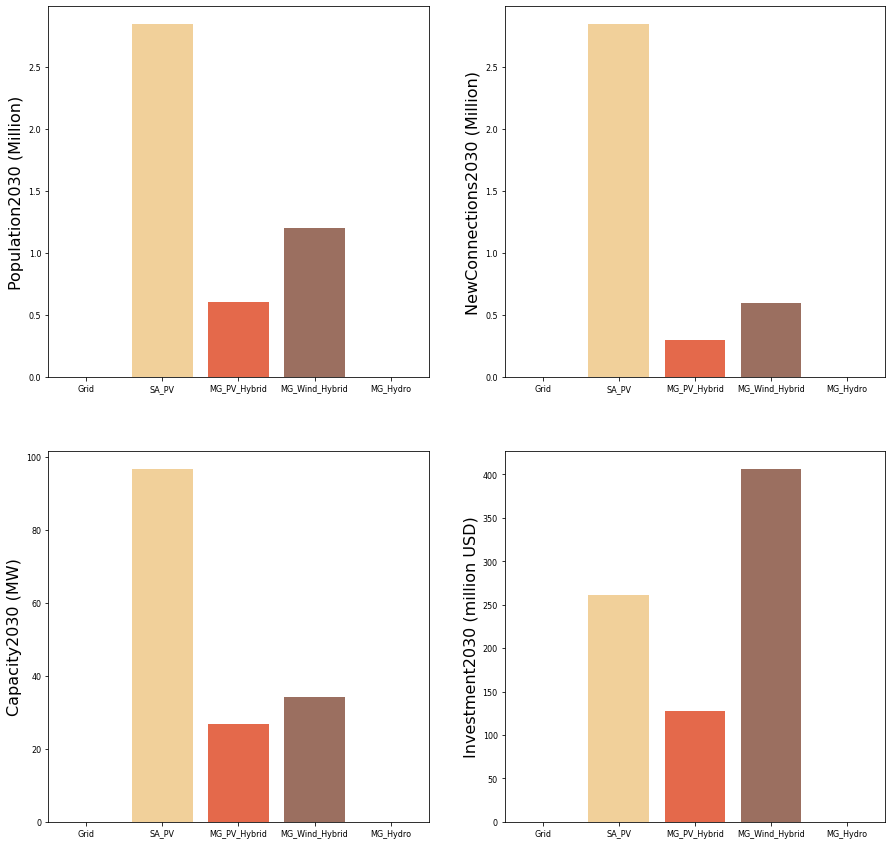

In [25]:
summary_plot = summary_plots(summary_table, yearsofanalysis)

The cells below shows the map of least-cost technologies for either the intermediate year or the end year of the analysis

In [26]:
result_year = end_year # Choose either *end_year* or *intermediate_year*
population_threshold = 500  # Display only settlements with a population larger than the threshold. Lowering the threshold will increase the loading time significantly

In [27]:
m = least_cost_map(onsseter.df, intermediate_year, end_year, population_threshold, result_year)

display(Markdown('Colour coding for technology split:'))
display(HTML('<font color="{}">&bull;Grid</font>&nbsp;&nbsp;&nbsp;<font color="{}">&bull;Extended mini-grids</font>&nbsp;&nbsp;&nbsp;\
              <font color="{}">&bull;Hybrid mini-grid PV</font>&nbsp;&nbsp;&nbsp;\
              <font color="{}">&bull;Hybrid mini-grid wind</font>&nbsp;&nbsp;&nbsp;<font color="{}">&bull;Mini-grid hydro</font>&nbsp;&nbsp;&nbsp;\
              <font color="{}">&bull;Stand-alone PV</font>&nbsp;&nbsp;&nbsp;<font color="{}">&bull;Unelectrified</font>'.format('#73B2FF','#73B2FF','#FE5931','#A56A56','#00518E','#FFD38C','lightgray')))

m 

Colour coding for technology split:

## 8. Exporting results

This code generates three csv files:
 - one containing all the results for the scenario created
 - one containing the summary for the scenario created
 - one containing some if the key input variables of the scenario

First write the scenario_name in the first cell below. Then move on to the cells below and run them to save the scenario results.

**Note that if you do not change the scenario name, the previous output files will be overwritten**

In [28]:
scenario_name = "Scenario_1"

In [29]:
list1 = [('Start_year',start_year,'','',''), 
         ('Intermediate target year', intermediate_year,'','',''),
         ('Intermediate electrification rate target', intermediate_year_electrification_rate_target,'','',''),
         ('End_year',end_year,'','',''),
         ('End year electrification rate target',end_year_electrification_rate_target,'','',''),
         ('Urban demand low', urban_demand_low, '', '', ''),
         ('Urban demand high', urban_demand_high, '', '', ''),
         ('Rural demand low', rural_demand_low, '', '', ''),
         ('Rural demand high', rural_demand_high, '', '', ''),
         ('Electrification strategy', electrification_strategy, '', '', ''),
         ('Intensification distance', intensification_distance, '', '', 'Buffer distance (km) for automatic intensification if choosing prioritization 1'),
         ('discount_rate',discount_rate,'','',''),
         ('pop_start_year', pop_start_year,'','','the population in the base year (e.g. 2020)'),
         ('Urban population growth rate',urban_pop_growth_rate,'','',''),
         ('Rural population growth rate',rural_pop_growth_rate,'','',''),
         ('num_people_per_hh_urban',num_people_per_hh_urban,'','','the number of people per household expected during the analysis'),
         ('num_people_per_hh_rural',num_people_per_hh_rural,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('grid_generation_cost',grid_generation_cost,'','','This is the grid cost electricity USD/kWh as expected in the end year of the analysis'),
         ('grid_power_plants_capital_cost',grid_power_plants_capital_cost,'','','The cost in USD/kW to for capacity upgrades of the grid-connected power plants'),
         ('grid_losses',grid_losses,'','','The fraction of electricity lost in transmission and distribution (percentage)'),
         ('diesel_price',diesel_price,'','','This is the diesel price in USD/liter as expected in the end year of the analysis'),
         ('mg_hydro_capital_cost',mg_hydro_capital_cost,'','','Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis'),
         ('sa_pv_capital_cost_1',sa_pv_capital_cost_1,'','','Stand-alone PV capital cost (USD/kW) for household systems under 20 W'),
         ('sa_pv_capital_cost_2',sa_pv_capital_cost_2,'','','Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W'),
         ('sa_pv_capital_cost_3',sa_pv_capital_cost_3,'','','Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W'),
         ('sa_pv_capital_cost_4',sa_pv_capital_cost_4,'','','Stand-alone PV capital cost (USD/kW) for household systems between 101-200 W'),
         ('sa_pv_capital_cost_5',sa_pv_capital_cost_5,'','','Stand-alone PV capital cost (USD/kW) for household systems over 200 W'),
         ('mv_line_cost',mv_line_cost,'','','Cost of MV lines in USD/km'),
         ('lv_line_cost',lv_line_cost,'','','Cost of LV lines in USD/km'),
         ('mv_line_capacity',mv_line_capacity,'','','Capacity of MV lines in kW/line'),
         ('lv_line_capacity',lv_line_capacity,'','','Capacity of LV lines in kW/line'),
         ('lv_line_max_length',lv_line_max_length,'','','Maximum length of LV lines (km)'),
         ('hv_line_cost',hv_line_cost,'','','Cost of HV lines in USD/km'),
         ('mv_line_max_length',mv_line_max_length,'','','Maximum length of MV lines (km)'),
         ('hv_mv_transformer_cost',hv_mv_transformer_cost,'','','Cost of HV/MV transformer (USD/unit)'),
         ('Diesel generator cost', diesel_generator_cost, '', '', ''),
         ('PV panel cost', mg_pv_panel_cost, '', '', ''),
         ('Wind_turbine_cost', wind_turbine_cost, '', '', ''),
         ('battery_cost', battery_cost, '', '', '')
         ]
labels = ['Variable','Value', 'Source', 'Comments', 'Description']
df_variables = pd.DataFrame.from_records(list1, columns=labels)

In [30]:
output_dir_variables = os.path.join('Results', '{}_Variables.csv'.format(scenario_name))
output_dir_results = os.path.join('Results', '{}_Results.csv'.format(scenario_name))
output_dir_summaries = os.path.join('Results', '{}_Summaries.csv'.format(scenario_name))

In [31]:
# Returning the result as a csv file
onsseter.df.to_csv(output_dir_results, index=False)

# Returning the summary as a csv file
summary_table.to_csv(output_dir_summaries, index=True)

# Returning the input variables as a csv file
df_variables.to_csv(output_dir_variables, index=False)

**Run the code below to save the electrification map**

In [32]:
map_tech_output = 'maps/map_{}_tech.html'.format(scenario_name)
m.save(map_tech_output)